https://www.tensorflow.org/tutorials/load_data/text

In [1]:
!pip install "tensorflow-text==2.13.*"

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 52.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 65.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 69.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.9 MB/s eta 0:00:00:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: tf-keras
    Found existing inst

In [2]:
import collections
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

In [3]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = utils.get_file(
    origin=data_url,
    untar=True,
    cache_dir='stack_overflow',
    cache_subdir='')

dataset_dir = pathlib.Path(dataset_dir).parent

6053168/6053168 [==============================] - 0s 0us/step


In [4]:
list(dataset_dir.iterdir())

[PosixPath('/tmp/.keras/test'),
 PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 PosixPath('/tmp/.keras/README.md'),
 PosixPath('/tmp/.keras/train')]

In [5]:
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/java'),
 PosixPath('/tmp/.keras/train/csharp'),
 PosixPath('/tmp/.keras/train/javascript'),
 PosixPath('/tmp/.keras/train/python')]

In [6]:
sample_file = train_dir/'python/1755.txt'

with open(sample_file) as f:
  print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



In [7]:
batch_size = 32
seed = 42

raw_train_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

In [9]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [10]:
# Create a validation set.
raw_val_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [11]:
test_dir = dataset_dir/'test'

# Create a test set.
raw_test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [12]:
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

In [14]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

In [15]:
# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [16]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", first_label)

Question: tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int32)


'binary' vectorized question: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,

(0.0, 1000.0)

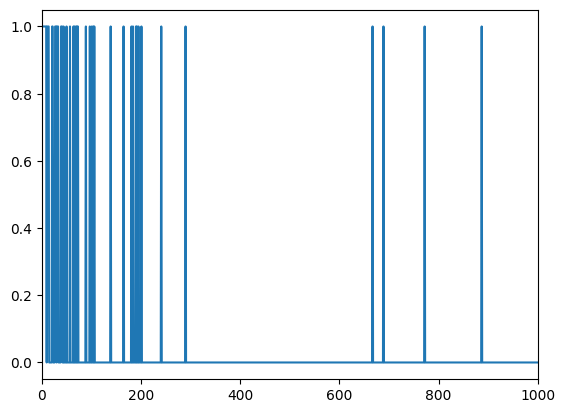

In [17]:
print("'binary' vectorized question:",
      list(binary_vectorize_layer(first_question).numpy()))

plt.plot(binary_vectorize_layer(first_question).numpy())
plt.xlim(0,1000)

In [18]:
print("'int' vectorized question:",
      int_vectorize_layer(first_question).numpy())

'int' vectorized question: [1011  773    9 2456    8 1863 2362  690 1267    4   40    5    1 1011
  196   12   74   13   72   33    2   98  105   14    3   70 9611    3
   34  888  202  773  107    8   41  242   40   58  291   90    3  196
  191   10    2  182    6  668    6   13   30 1187   12  773   22   42
    1   28    5  140   29 5213   15   29    1   28   51    1    1    1
    7   23   30    3  291   10   67    6   32   65  185  166  102   14
    2   65    6    1  193    9 2784   45 2410    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

In [19]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  roman
313 --->  source
Vocabulary size: 10000


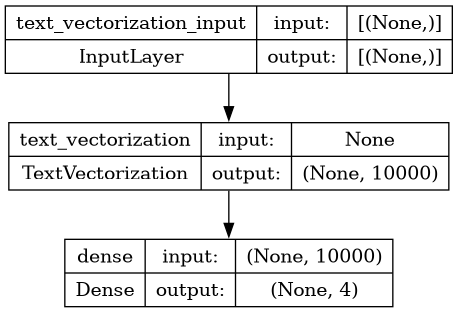

In [20]:
binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

tf.keras.utils.plot_model(binary_model, show_shapes=True)

In [21]:
bin_history = binary_model.fit(
    raw_train_ds, validation_data=raw_val_ds, epochs=10)

print()

Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 1.1097 - accuracy: 0.6525 - val_loss: 0.9103 - val_accuracy: 0.7806
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.7748 - accuracy: 0.8169 - val_loss: 0.7486 - val_accuracy: 0.8025
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.6252 - accuracy: 0.8586 - val_loss: 0.6638 - val_accuracy: 0.8188
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.5325 - accuracy: 0.8855 - val_loss: 0.6107 - val_accuracy: 0.8256
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4669 - accuracy: 0.9034 - val_loss: 0.5743 - val_accuracy: 0.8344
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.4168 - accuracy: 0.9177 - val_loss: 0.5478 - val_accuracy: 0.8363
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3768 - accuracy: 0.9303 - val_loss: 0.5279 - val_accuracy: 0.8375
Epoch 

In [22]:
def create_model(vocab_size, num_labels, vectorizer=None):
  my_layers =[]
  if vectorizer is not None:
    my_layers = [vectorizer]

  my_layers.extend([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Dropout(0.5),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ])

  model = tf.keras.Sequential(my_layers)
  return model

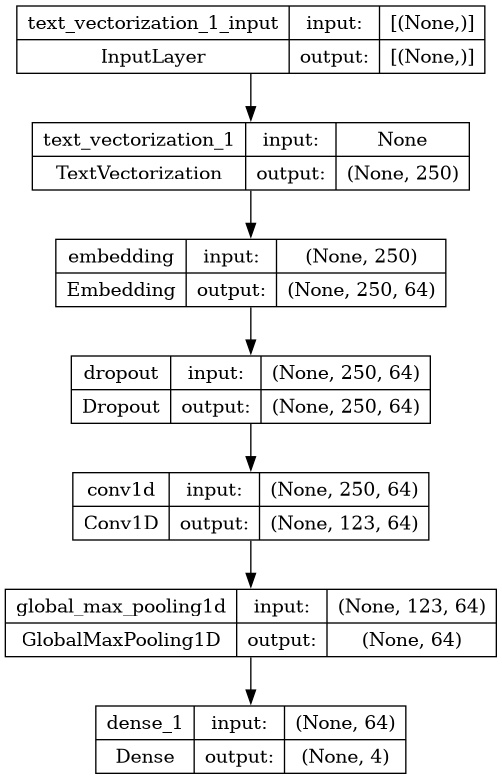

In [23]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=4, vectorizer=int_vectorize_layer)

tf.keras.utils.plot_model(int_model, show_shapes=True)

In [24]:
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
int_history = int_model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=10)

Epoch 1/10
200/200 [==============================] - 5s 22ms/step - loss: 1.2850 - accuracy: 0.4073 - val_loss: 1.0028 - val_accuracy: 0.6175
Epoch 2/10
200/200 [==============================] - 5s 23ms/step - loss: 0.8076 - accuracy: 0.6631 - val_loss: 0.6536 - val_accuracy: 0.7337
Epoch 3/10
200/200 [==============================] - 5s 23ms/step - loss: 0.5837 - accuracy: 0.7731 - val_loss: 0.5530 - val_accuracy: 0.7950
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.4328 - accuracy: 0.8478 - val_loss: 0.4890 - val_accuracy: 0.8238
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3112 - accuracy: 0.8994 - val_loss: 0.4710 - val_accuracy: 0.8181
Epoch 6/10
200/200 [==============================] - 5s 23ms/step - loss: 0.2236 - accuracy: 0.9361 - val_loss: 0.4832 - val_accuracy: 0.8100
Epoch 7/10
200/200 [==============================] - 5s 23ms/step - loss: 0.1565 - accuracy: 0.9580 - val_loss: 0.4988 - val_accuracy: 0.8138

Text(0, 0.5, 'CE/token')

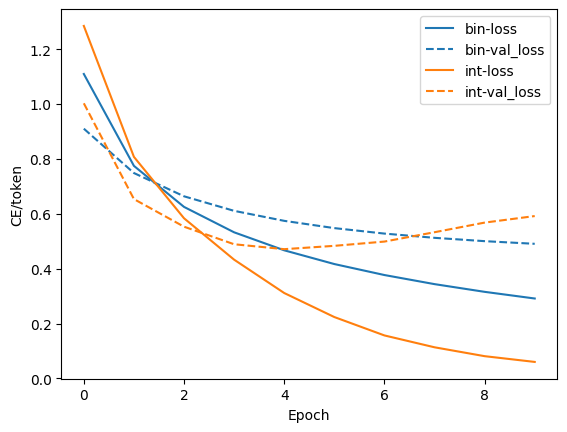

In [25]:
loss = plt.plot(bin_history.epoch, bin_history.history['loss'], label='bin-loss')
plt.plot(bin_history.epoch, bin_history.history['val_loss'], '--', color=loss[0].get_color(), label='bin-val_loss')

loss = plt.plot(int_history.epoch, int_history.history['loss'], label='int-loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color=loss[0].get_color(), label='int-val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('CE/token')

In [ ]:
binary_train_ds = raw_train_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_val_ds = raw_val_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_test_ds = raw_test_ds.map(lambda x,y: (binary_vectorize_layer(x), y))

int_train_ds = raw_train_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_val_ds = raw_val_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_test_ds = raw_test_ds.map(lambda x,y: (int_vectorize_layer(x), y))

In [26]:
binary_model.export('bin.tf')

Saved artifact at 'bin.tf'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: string Tensor, shape=(None,)
  Returns:
    float32 Tensor, shape=(None, 4)


In [27]:
loaded = tf.saved_model.load('bin.tf')

In [28]:
binary_model.predict(['How do you sort a list?'])

1/1 [==============================] - 0s 167ms/step


array([[-0.09057535,  0.01109988, -0.641136  ,  0.38702974]],
      dtype=float32)

In [29]:
loaded.serve(tf.constant(['How do you sort a list?'])).numpy()

array([[-0.09057535,  0.01109988, -0.641136  ,  0.38702974]],
      dtype=float32)